<img src="img/banner.png" width = 90%>


## Transfer Learning : classification d’images médicales à partir de modèles pré-entraînés de type CNN.

Projet de mise en place d'un système de classification binaire permettant de détecter des cas de pneumonie à partir de radios thoraciques, via utilisation d'un *modèle de vision par ordinateur préentraîné* type *CNN*. Utilisation du dataset *Chest X-Ray Pneumonia*.

Appréhension d'une démarche de suivi des expérimentations par *MLflow*, afin de tracer les paramètres d’entraînement, les métriques de performance et les versions de modèle.

**Contexte du projet** : Une équipe médicale souhaite tester l’apport de l’intelligence artificielle dans le diagnostic automatisé de la pneumonie à partir de radios thoraciques. Elle a besoin d’un prototype fonctionnel (Proof of Concept) permettant de démontrer la faisabilité d’un système de classification binaire d’images médicales.

_______________________________________________________________________________________________________________________________________________________

### Import des bibliothèques

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import class_weight
import mlflow
import random

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

#from tensorflow.keras.applications import DenseNet121   # DenseNet121 = modèle très utilisé dans le domaine médical pour la détection
                                                        # de maladies pulmonaires. Testé, mais très lourd sur le processeur.

from tensorflow.keras.applications import MobileNetV3Small  # MobileNetV3 = modèle CNN plus général, mais plus léger
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input     # fonction préconisée pour la normalisation des données avec MobileNetV3




np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30)

# 1. Exploration des données

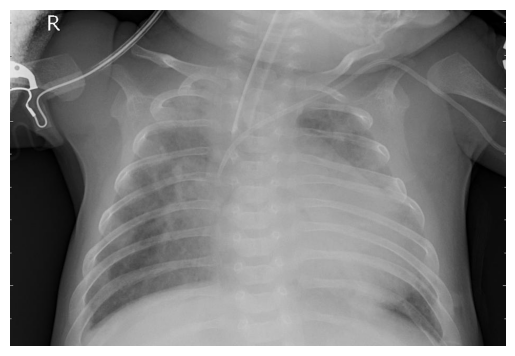

Shape (dimensions) : (640, 944, 3)
Type des valeurs : uint8


In [2]:
img = cv2.imread("data/test/PNEUMONIA/person1_virus_6.jpeg", cv2.IMREAD_COLOR_RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

print(f"Shape (dimensions) : {img.shape}")
print(f"Type des valeurs : {img.dtype}")

En testant l'affichage de plusieurs images et leurs dimensions, nous pouvons voir que les radios sont de formats différents.

_______________________________________________________________________________________________________________________________________________________

# 2. Préparation des données

Fonction permettant de redimensionner nos images, tout en gardant leur ratio d'origine avec un padding noir afin d'éviter les déformations.\
*224 x 224* était le format optimal avec DenseNet121.\
Avec MobileNetV3, plus le format d'image est grand, plus il sera performant.

In [3]:
#input_shape = (224, 224)

In [4]:
def resize_with_padding(img, target_size = (224, 224, 3)):
        h, w = img.shape[:2]
        scale = min(target_size[0]/h, target_size[1]/w)
        new_h, new_w = int(h * scale), int(w * scale)
        resized = cv2.resize(img, (new_w, new_h))

        padded = np.zeros(target_size, dtype=np.uint8)

        y_offset = (target_size[0] - new_h) // 2
        x_offset = (target_size[1] - new_w) // 2

        padded[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
        return padded

Fonction parcourant nos dossiers afin de charger les photos. Chaque sous-dossier représente une classe (radio de poumons sains, ou atteints de pneumonie). Les datas sont initialement séparées en trois dossiers train, test, et val pour faciliter le travail.

In [5]:
def get_train_test(base_path: str):
    X = [] # images
    y = [] # labels
    label_to_int = {"NORMAL" : 0, "PNEUMONIA" : 1}

    for label in sorted(os.listdir(base_path)):
        label_path = os.path.join(base_path, label)

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            img = cv2.imread(file_path, cv2.IMREAD_COLOR_RGB)
            if img is None:
                print("Image illisible : ", file_path)
                continue
            img = resize_with_padding(img)
            X.append(img)
            y.append(label_to_int[label])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [6]:
# Créer un générateur d'images avec normalisation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
X_train, y_train = get_train_test("data/train")
X_test, y_test = get_train_test("data/test")
X_val, y_val = get_train_test("data/val")

X_test_display = X_test.copy()      # pour garder une copie de l'image d'origine afin de l'afficher lors de la prédiction

In [8]:
train_generator = datagen.flow(X_train, y_train, batch_size=32)
valid_generator = datagen.flow(X_val, y_val, batch_size=32)
test_generator = datagen.flow(X_test, y_test, batch_size=32)

Visualisation des 10 premières radios pour vérifier le fonctionnement du traitement précédent.

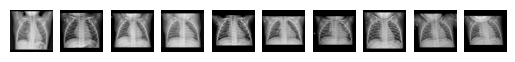

In [9]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.axis("off")

plt.show()

Fonction permettant de rééquilibrer les classes afin d'améliorer l'apprentissage. Evite au modèle de favoriser les classes majoritaires.

In [10]:
def compute_class_weights(y):
    # Calculer les poids de classe
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',    # equilibre automatiquement selon la fréquence
        classes=np.unique(y),       #classes présentes
        y=y)    # vecteur des étiquettes
    
    # Créer un dictionnaire de poids
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    return class_weight_dict

# Calculer les class_weights
class_weights = compute_class_weights(y_train)

_______________________________________________________________________________________________________________________________________________________

# 3. Preprocessing

**Avec DenseNet121 :**\
Ici nous convertissons le format *int* des pixels de nos images en format *float32*, pour ensuite normaliser nos données :\
- Division par 255 pour passer la valeur des pixels entre 0 et 1
- Normalisation par la même moyenne et le même écart-type utilisés avec les poids d'ImageNet.

In [11]:
# X_train = X_train.astype("float32") / 255.0
# X_test = X_test.astype("float32") / 255.0

# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])

# X_train = (X_train - mean) / std
# X_test = (X_test - mean) / std

# display(X_train.shape)
# display(X_test.shape)

**Avec MobileNetV3 :**\
Utilisation de la fonction *preprocess_input* dédiée à la normalisation des données pour MobileNetV3

In [12]:
# X_train = preprocess_input(X_train.astype(np.float32))
# X_val = preprocess_input(X_val.astype(np.float32))
# X_test = preprocess_input(X_test.astype(np.float32))

display(X_train.shape)
display(X_val.shape)
display(X_test.shape)

(5216, 224, 224, 3)

(16, 224, 224, 3)

(624, 224, 224, 3)

_______________________________________________________________________________________________________________________________________________________

# 4. Modélisation

### a. Importation du modèle, paramétrage, et compilation

Nous créons le modèle sur la base du modèle pré-entraîné **MobileNetV2**, modèle CNN performant sur la classification d'images.\
**DenseNet121** à été précedemment testé, il est très utilisé dans le domaine médical notamment dans la détection de maladie pulmonaires, mais il demande beaucoup de performances au processeur pour faire ses calculs. Malgré des résultats moins élevés, j'utilise un modèle plus léger pour raisons pédagogiques.

Nous importons le modèle avec ses *poids pré-entraînés* (sur *ImageNet*), c'est pourquoi nous avons dû précédemment normaliser nos données avec une certaine moyenne et un certain écart-type, les mêmes que lors de l'entraînement initial du modèle. 

Nous n'utilisons pas sa dernière couche (*include-top = False*) afin d'ajouter les couches (*model_outputs*) qui nous intéresse pour le résultat que nous recherchons.

In [13]:
# choix des paramètres de compilation

optimizer = 'adam'
loss_function = 'binary_crossentropy'

In [14]:

inputs = Input(shape=(224, 224, 3))

# Importation du modèle avec les poids pré-entraîné d'ImageNet, et en excluant la dernière couche (include-top=False)
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_tensor=inputs)

# Gel des couches du modèle pré-entraîné
base_model.trainable = False

# Création des couches hautes
model_outputs = base_model.output
model_outputs = GlobalAveragePooling2D()(model_outputs)
model_outputs = Dense(1, activation='sigmoid')(model_outputs)

# Création du modèle
model = Model(inputs=inputs, outputs = model_outputs)

# Compilation du modèle
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

### b. Résumé du modèle

Nous pouvons voir toutes les couches de notre modèle. Initialement, il ne prend pas en compte les paramètres des couches gelées.

In [15]:
# model.summary()

_______________________________________________________________________________________________________________________________________________________

# 5. Entraînement du modèle avec gel des couches basses

On définit un arrêt automatique pour éviter le surapprentissage, et réduire le temps d'entraînement inutile. Il servira également lors de l'entraînement suivant (avec plus de couches activées).

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)   # Surveillance pour empêcher le surapprentissage

nb_epochs = 10
batch_size = 32

### a. Entraînement

In [17]:
# history_freeze = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=nb_epochs,
#     batch_size = batch_size,
#     class_weight = class_weights,
#     callbacks=[early_stop], 
#     verbose=1
# )

In [18]:
history_freeze = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=valid_generator,
    validation_steps=len(X_val) // 32,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)

c:\Users\Utilisateur\Documents\PROJETS\02 - Transfer Learning\CNN_Transfer_Learning\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 327ms/step - accuracy: 0.7835 - loss: 0.4674 - val_accuracy: 0.8750 - val_loss: 0.2922
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 346ms/step - accuracy: 0.9010 - loss: 0.2339 - val_accuracy: 0.8125 - val_loss: 0.3589
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 356ms/step - accuracy: 0.9137 - loss: 0.2136 - val_accuracy: 0.8125 - val_loss: 0.3559
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 332ms/step - accuracy: 0.9224 - loss: 0.1899 - val_accuracy: 0.8125 - val_loss: 0.2770
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 391ms/step - accuracy: 0.9311 - loss: 0.1718 - val_accuracy: 0.8125 - val_loss: 0.4452
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 325ms/step - accuracy: 0.9320 - loss: 0.1691 - val_accuracy: 0.9375 - val_loss: 0.2732
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 327ms/step - accuracy: 0.9360 - loss: 0.1570 - val_accuracy: 0.8125 - val_loss: 0.4810
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 338ms/step - accuracy: 0.9460 - loss: 0

### b. Evaluation de la précision

In [19]:
loss_freeze, accuracy_freeze = model.evaluate(X_test, y_test)
print(f"Précision : {accuracy_freeze*100:.2f}%")
print(f"Pertes : {loss_freeze}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8383 - loss: 0.3675
Précision : 88.78%
Pertes : 0.27097171545028687


_______________________________________________________________________________________________________________________________________________________

# 6. Entraînement du modèle avec ajout de couches du modèle de base

Après avoir entraîné les dernières couches du modèle (que nous avons ajouté spécifiquement pour notre projet = outputs), nous dégelons les 30 dernières couches afin d'essayer d'optimiser au mieux les performances du modèle.\
(Avec **DenseNet121** il était difficilement possible d'ajouter plus de 15 couches pour l'optimisation, en raison d'un manque de performances de l'ordinateur.)

### a. Modélisation

In [20]:
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

### b. Résumé du modèle

In [21]:
#model.summary()

### b. Entraînement

In [22]:
# history_nofreeze = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=nb_epochs,
#     batch_size = batch_size,
#     class_weight = class_weights,
#     callbacks=[early_stop], 
#     verbose=1
# )

In [23]:
history_nofreeze = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=valid_generator,
    validation_steps=len(X_val) // 32,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 366ms/step - accuracy: 0.9256 - loss: 0.1888 - val_accuracy: 0.9375 - val_loss: 0.2498
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 340ms/step - accuracy: 0.9548 - loss: 0.1115 - val_accuracy: 0.9375 - val_loss: 0.1710
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 341ms/step - accuracy: 0.9602 - loss: 0.0972 - val_accuracy: 0.8750 - val_loss: 0.3417
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 332ms/step - accuracy: 0.9698 - loss: 0.0720 - val_accuracy: 1.0000 - val_loss: 0.0809
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 330ms/step - accuracy: 0.9708 - loss: 0.0767 - val_accuracy: 0.9375 - val_loss: 0.0774
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 338ms/step - accuracy: 0.9773 - loss: 0.0603 - val_accuracy: 0.8125 - val_loss: 0.5302
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 335ms/step - accuracy: 0.9700 - loss: 0.0687 - val_accuracy: 0.7500 - val_loss: 0.3180
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 326ms/step - accuracy: 0.9735 - loss: 0

### c. Evaluation de la précision

In [24]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Précision : {accuracy*100:.2f}%")
print(f"Pertes : {loss}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8692 - loss: 0.3472
Précision : 91.51%
Pertes : 0.24110211431980133


### d. Matrice de confusion

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step
Classification Report :

              precision    recall  f1-score   support

      Normal       0.95      0.82      0.88       234
   Pneumonia       0.90      0.97      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.91       624



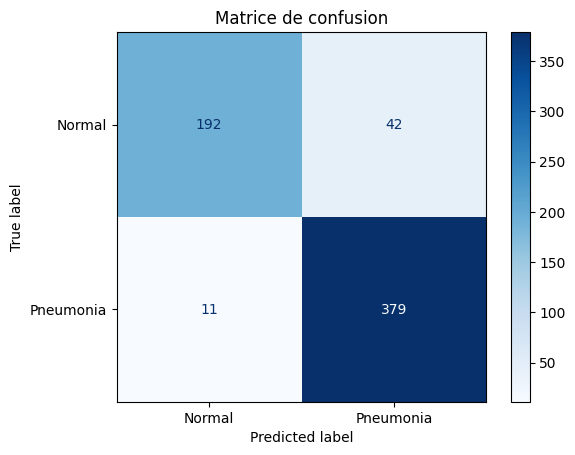

In [25]:
y_pred_proba = model.predict(X_test)

y_pred = (y_pred_proba > 0.5).astype("int32").flatten()

print("Classification Report :\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "Pneumonia"]))
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()


### e. Courbe de vérification de l'overfitting

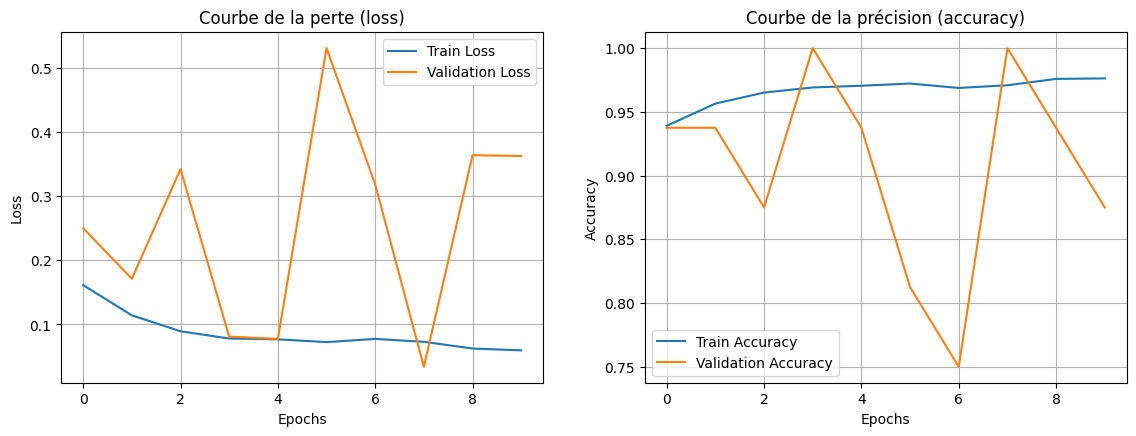

In [26]:
plt.figure(figsize=(12, 5))

# Courbe de perte (loss)
plt.subplot(1, 2, 1)
plt.plot(history_nofreeze.history['loss'], label='Train Loss')
plt.plot(history_nofreeze.history['val_loss'], label='Validation Loss')
plt.title('Courbe de la perte (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Courbe de précision (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history_nofreeze.history['accuracy'], label='Train Accuracy')
plt.plot(history_nofreeze.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de la précision (accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout(pad=3.0)

plt.show()

Avec *DenseNet121*, les courbes ne semblaient pas très pertinentes, car avec notre entraînement, l'arrêt automatique par le *EarlyStop* était déclenché au bout de 4 epochs. Avec un entraînement sur un plus grand nombre de couches dégelées (ici à 15), il y aurait peut-être eu un plus grand nombre d'epochs parcouru, et donc des courbes plus précises.

_______________________________________________________________________________________________________________________________________________________

# 7. Prédiction

Test de l'efficacité de notre modèle par prédiction. Une image est sélectionnée aléatoirement à chaque exécution.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


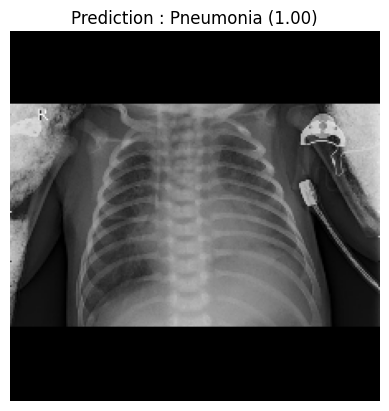

In [27]:
# Mapping des classes
label_name = {0: "Normal", 1: "Pneumonia"}

# Choix aléatoire d'une image dans X_test
img_to_predict = random.randint(0, len(X_test) - 1)

# Obtenir la prédiction (proba)
proba = model.predict(X_test[[img_to_predict]])[0][0]

# Classer selon le seuil 0.5
predicted_class = int(proba > 0.5)

# Afficher l’image avec prédiction
#plt.imshow(X_test[img_to_predict])
plt.imshow(X_test_display[img_to_predict].astype(np.uint8))
plt.title(f"Prediction : {label_name[predicted_class]} ({proba:.2f})")
plt.axis("off")
plt.show()

_______________________________________________________________________________________________________________________________________________________

# 8. Mise en place du MLFlow

Ici nous centralisons dans un dictionnaire les paramètres qui nous intéresse pour le suivi des expériences.

In [28]:
# Centralisation des paramètres du modèle

params = {
    "model": "MobileNetV3Small",
    "input_shape": (224, 224, 3),
    "batch_size": batch_size,
    "epochs": nb_epochs,
    "optimizer": optimizer,
    "loss_function": loss_function,
    "early_stop_patience": early_stop.patience,
    "early_stop_monitor": early_stop.monitor,
    "early_stop_resto_best_weights": early_stop.restore_best_weights,
    "Two_phase_training": True
}

Nous suivons l'expérience sous le nom **Pneumonia detection**\
Nous enregistrons les *paramètres* utilisé en parcourant le dictionnaire dédié, ainsi que l'évaluation des différents métriques.\
Nous générons aussi des graphiques de suivi des *métriques de performance*, retrouvables dans l'onglet Artifacts de MLFlow.

In [29]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment("Pneumonia detection - MobileNetV3Small (ImageDataGenerator)")

with mlflow.start_run(run_name="Pneumonia detection - MobileNetV3Small"):
    
    for name, value in params.items():
        mlflow.log_param(name, str(value))

    mlflow.log_metric("val_loss", loss)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("f1_score", f1)

    def graph_metrics(history, recall, precision, f1, name):
        plt.figure(figsize=(14, 4))

        # --- Accuracy ---
        plt.subplot(1, 3, 1)
        plt.plot(history.history['accuracy'], label='train acc')
        plt.plot(history.history['val_accuracy'], label='val acc')
        plt.title("Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

        # --- Loss ---
        plt.subplot(1, 3, 2)
        plt.plot(history.history['loss'], label='train loss')
        plt.plot(history.history['val_loss'], label='val loss')
        plt.title("Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        # --- Bar plot des métriques ---
        plt.subplot(1, 3, 3)
        metrics = ['Recall', 'Precision', 'F1-score']
        values = [recall, precision, f1]
        colors = ['skyblue', 'lightgreen', 'salmon']
        bars = plt.bar(metrics, values, color=colors)
        plt.ylim(0, 1)
        plt.title("Validation Metrics")

        # Ajouter les valeurs sur les barres
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center')

        # Sauvegarde et log dans MLflow
        file_path = f"{name.replace(' ', '_')}_full_metrics.png"
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), file_path)
        plt.close()

    # 3.1 Tracer et logger les graphes
    #plot_and_log(history_freeze, "Phase 1 - Frozen")
    graph_metrics(history_nofreeze, recall, precision, f1, name="Results")

    # ==============================
    # 4. Logger le modèle final
    # ==============================
    mlflow.keras.log_model(model, "MobileNetV3Small")


2025/05/26 16:37:57 INFO mlflow.tracking.fluent: Experiment with name 'Pneumonia detection - MobileNetV3Small (ImageDataGenerator)' does not exist. Creating a new experiment.
2025/05/26 16:37:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/26 16:38:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Pneumonia detection - MobileNetV3Small at: http://127.0.0.1:5000/#/experiments/622871317738511015/runs/f900555264e54f20a116c684ac925671
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/622871317738511015


In [30]:
run_id = "f900555264e54f20a116c684ac925671"
model_uri = f'runs:/{run_id}/{params["model"]}'
result = mlflow.register_model(
   model_uri, params["model"]
)

Successfully registered model 'MobileNetV3Small'.
2025/05/26 16:41:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MobileNetV3Small, version 1
Created version '1' of model 'MobileNetV3Small'.
